この章では、VisionTransformer（ViT）を取り扱います。

前回までのTransformerの知識がフルで活かせるので、どうぞ体験していってください。

In [ ]:
#関数のインポート
import math
import torch
import torch.nn as nn

In [ ]:
# テンソルを見やすく表示する関数（スキップしても構いません）
def print_formatted_tensor(*args, width=6, decimals=2):
    """
    
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("名前", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    

    # 引数からテンソルと名前を決定する
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Tensorをリストに変換する
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """再帰的に入れ子になったリストを整形して文字列を返す"""
        # 内容がリストの場合は再度返す
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 数字リストの場合
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # フォーマット済み文字列（最外枠の角括弧は削除されます）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 結果出力
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")



torch.manual_seed(1337)


# Chapter 1：データの読み込み 

今回はCIFAR-10というデータセットを用います。

まずはデータセットについて知っておきましょう。機械学習エンジニアの第一歩です。

CIFAR-10はCanadian Institute for Advanced Researchというカナダ政府、アルバータ州およびケベック州の援助を得た研究機関が取りまとめたデータセットで、60,000枚の画像を10クラスに分類するためのデータセットです。

21世紀に入り、Hinton先生やLeCun先生、Bengio先生などのご活躍もあり、データセットが整備されました。いや〜本当にありがたい限りですね。

中身を見てみましょう。

In [123]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

In [124]:
import torchvision

trainset=torchvision.datasets.CIFAR10(root=r'.', 
                          train=True, download=True)

Files already downloaded and verified


データセットの概要を見てみます。

In [125]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train

namesリストを作成します。これはCIFAR10データセットではそれぞれのクラスラベルが0-9となっており、それに対応する言葉を振ったほうが見やすいからですね。

In [126]:
names = ['plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck']

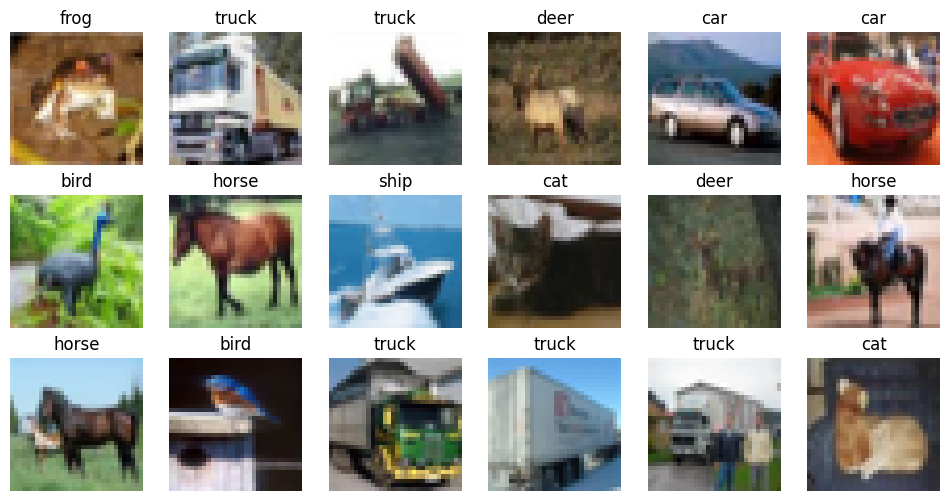

In [127]:
import matplotlib.pyplot as plt
import numpy as np 

# Create a 3 by 6 grid of pictures
plt.figure(figsize=(12,6),dpi=100)
for i in range(3):
    for j in range(6):
        plt.subplot(3, 6, 6*i+j+1)
        plt.imshow(trainset[6*i+j][0])
        plt.axis('off')
        plt.title(names[trainset[6*i+j][1]], fontsize=12)
plt.subplots_adjust(hspace=0.20)
plt.show()

若干画像が粗めですが、なんとなくは分かると思います。というかなんとなくわかってしまう人間の視覚って不思議だな、、、

他の画像でも見てみましょう。

In [128]:
testset=torchvision.datasets.CIFAR10(root=r'.', 
                          train=False, download=True)

Files already downloaded and verified


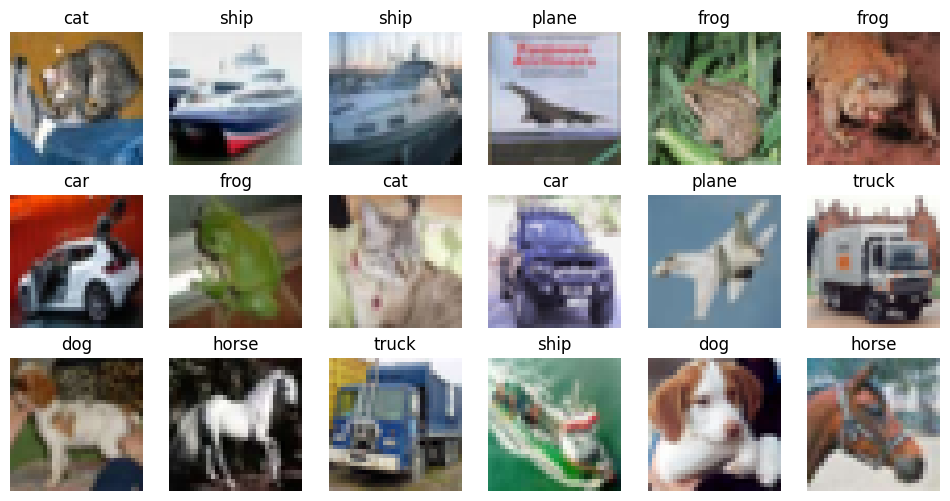

In [129]:
plt.figure(figsize=(12,6),dpi=100)
for i in range(3):
    for j in range(6):
        plt.subplot(3, 6, 6*i+j+1)
        plt.imshow(testset[6*i+j][0])
        plt.axis('off')
        plt.title(names[testset[6*i+j][1]], fontsize=12)
plt.subplots_adjust(hspace=0.20)
plt.show()

# Chapter 2：画像変換

さて、現在データセットはPythonのオブジェクトになっています。</br>
これをPyTorchで扱えるテンソルにしましょう。</br>
その際、機械学習の世界では「画像変換」を行います。これは同じ画像でも何かしらの画像変換を行うことで、画像に多様性を出すためのものです。

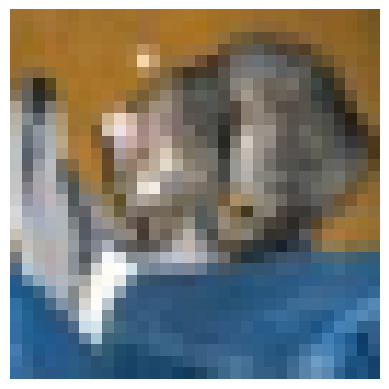

In [130]:
img, label = testset[0]  # 1つ目の画像とラベル

# 画像を表示する関数（TensorもPILもOK）
def show(img, title=""):
    if isinstance(img, torch.Tensor):
        # Normalizeされたものは可視化用に逆変換
        img = img.clone()
        img = img * 0.5 + 0.5  # mean=0.5, std=0.5 を戻す
        img = img.permute(1, 2, 0)  # (C,H,W)→(H,W,C)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
show(img) #最初の画像を見る

トムジェリ感すごいな</br>
さてここから画像変換を進めていきます。

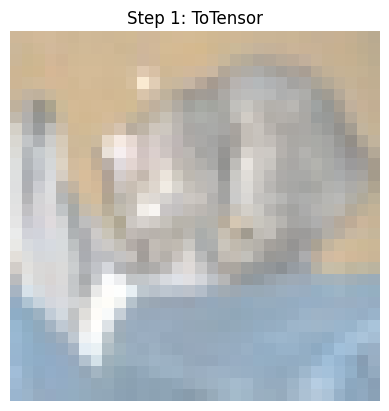

In [131]:
# TODO: 画像をテンソルに変換します
to_tensor = transforms.ToTensor()
img1 = to_tensor(img)
show(img1, "Step 1: ToTensor")

画素値が0-255から0-1に正規化されたことで、色が薄くなっていることがわかります。

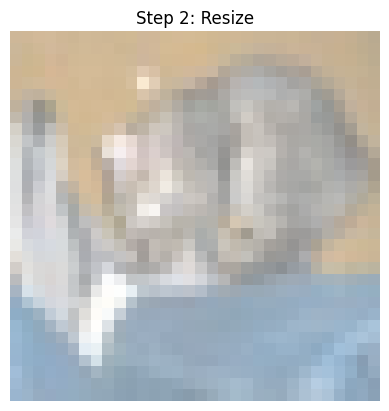

In [132]:
#TODO 画像をリサイズします
resize = transforms.Resize((32, 32), antialias=True)
img2 = resize(img1)
show(img2, "Step 2: Resize")

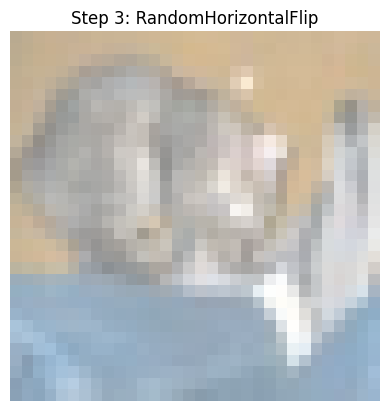

In [133]:
#TODO 画像をランダムに左右に反転させます
flip = transforms.RandomHorizontalFlip(p=1.0)
img3 = flip(img2)
show(img3, "Step 3: RandomHorizontalFlip")


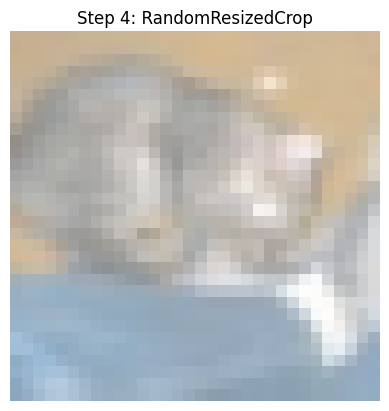

In [134]:
# TODO 画像を一定の確率で切り取ります。
torch.manual_seed(0)
crop = transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0),
                                    ratio=(0.75, 1.3333),
                                    interpolation=2, antialias=True)
img4 = crop(img3)
show(img4, "Step 4: RandomResizedCrop")

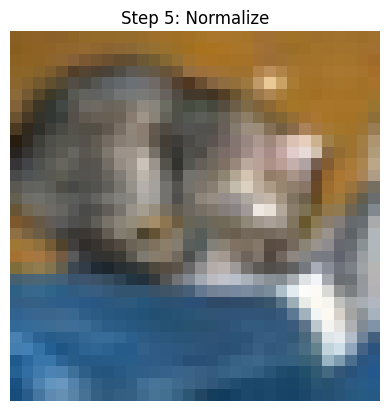

In [135]:
#TODO 画像を正規化させます。
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
img5 = normalize(img4)
show(img5, "Step 5: Normalize")

In [136]:
#上記の処理を１つにまとめたインスタンス
import torchvision.transforms as transforms

trainset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0),
                 ratio=(0.75, 1.3333333333333333), 
                 interpolation=2,antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test側も同様に処理を行います。このとき反転やRandomCropは入れません。

＜なぜ？＞

In [137]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True)
testset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False)


# Chapter3 Patch Encoding

ViTは簡単に言えば画像向けのTransformerです。</br>
Transformerは単語生成などの系列情報の予測に利用されていましたが、ViTでは画像をTransformerに応用します。</br>
そのためには、画像を「系列情報」に変換しなければなりません。ここのアイデアは、畳み込みでも画像を１次元に変換して全結合層につなげる、という考えをしたのと同様に、画像を細かい単位に分割して、それを横一列にならべて「系列情報」とすることでtransformerを噛ませます。

この動画のように、画像をいくつかのコマに分割して並べる必要があります。</br>
この方法を「patch encoding」といいます。</br>
それではさっそく、この中の画像を１つ取ってきて、patch encodingを実装してみましょう。

In [138]:
#可能ならcuda環境を用います。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


classを定義します。patch encodingのために必要な情報です。

In [139]:
class Config:
    patch_size=8
    hidden_size=48
    num_hidden_layers=4
    num_attention_heads=4
    intermediate_size= 4 * 48
    image_size=32
    num_classes=10 
    num_channels=3
config=Config()

configの内容を反映させましょう。</br>
🔘 **Options**: 以下の選択肢から選びましょう。いらないものが含まれているかもしれません。

`nn.Module`  `config.patch_size`  `config.patch_size` `zero` `config()`


In [140]:
import torch.nn as nn

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.projection = nn.Conv2d(config.num_channels,
                                    config.hidden_size, 
                                    kernel_size=config.patch_size, 
                                    stride=config.patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x  

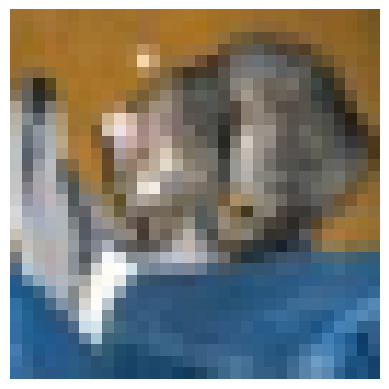

In [141]:
show(img)

tokens.shape: (1, 16, 48)


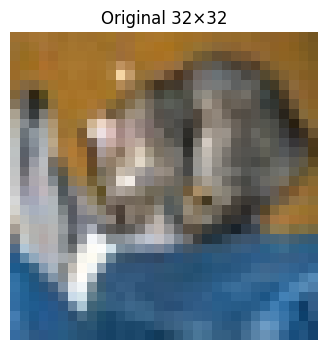

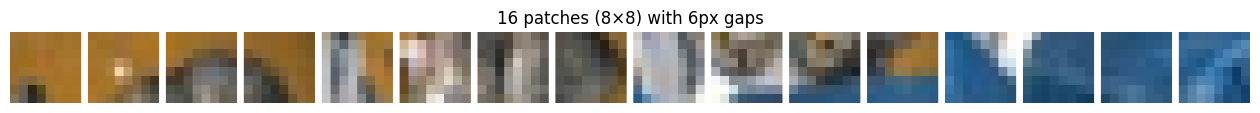

In [142]:
#ここの理解は難しいので不要
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

patcher = PatchEmbeddings(config)

# img -> [3,32,32] CHW, [0..1] に整形（必要なら変換）
def to_chw32(img, image_size=32):
    if isinstance(img, np.ndarray):
        arr = img.astype(np.float32)
        if arr.max() > 1.0: arr /= 255.0
        if arr.ndim == 3 and arr.shape[-1] == 3:
            t = torch.from_numpy(arr).permute(2,0,1).contiguous()
        elif arr.ndim == 3 and arr.shape[0] == 3:
            t = torch.from_numpy(arr)
        else:
            raise ValueError("numpy img must be HWC(… ,…,3) or CHW(3,…, …).")
    elif isinstance(img, torch.Tensor):
        t = img
        if t.ndim != 3: raise ValueError("torch img must be 3D (CHW or HWC).")
        if t.shape[-1] == 3: t = t.permute(2,0,1).contiguous()
        if t.dtype != torch.float32 or t.max() > 1.0: t = t.float() / 255.0
    else:
        raise ValueError("img must be np.ndarray or torch.Tensor")
    if t.shape[1:] != (image_size, image_size):
        t = F.interpolate(t.unsqueeze(0), size=(image_size,image_size),
                          mode="bilinear", align_corners=False).squeeze(0)
    return t.clamp(0,1)

img_tensor = to_chw32(img1, image_size=config.image_size)  # [3,32,32]

# 1) トークン化（確認用）
with torch.no_grad():
    tokens = patcher(img_tensor.unsqueeze(0))             # [1, 64, 48]（32/4=8 → 8×8=64）
print("tokens.shape:", tuple(tokens.shape))

# 2) 可視化用に画像をパッチ分割 → 各パッチを拡大
ps = config.patch_size
unfold = torch.nn.Unfold(kernel_size=ps, stride=ps)
patches = unfold(img_tensor.unsqueeze(0))                 # [1, C*ps*ps, L], L=64
C = img_tensor.shape[0]; L = patches.shape[-1]
patches = patches.view(1, C, ps*ps, L).permute(3,1,2,0).contiguous().view(L, C, ps, ps)

# 必要なら最初の16パッチだけ使う場合（任意）
use_first = 16   # 64全部なら None に
if use_first is not None:
    patches = patches[:use_first]
    L = patches.shape[0]

# 拡大（見やすさ用）
vis_size = 64
upsampled = F.interpolate(patches, size=(vis_size, vis_size), mode="nearest")  # [L,3,H,W]

# 3) パッチ間ギャップを挿入して横結合
gap = 6                          # ← 隙間の太さ（ピクセル）
sep_val = 1.0                    # ← 1.0で白、0.0で黒。好みで変更可
pieces = []
for i in range(L):
    pieces.append(upsampled[i])  # [3,H,W]
    if i != L-1:
        sep = torch.full((3, vis_size, gap), sep_val, dtype=upsampled.dtype, device=upsampled.device)
        pieces.append(sep)
row = torch.cat(pieces, dim=2)   # [3, H, L*W + (L-1)*gap]
row_img = row.permute(1,2,0).cpu().numpy()  # HWC

# 4) 描画
plt.figure(figsize=(4,4))
plt.imshow(img_tensor.permute(1,2,0).cpu().numpy())
plt.title("Original 32×32")
plt.axis("off")
plt.show()

plt.figure(figsize=(16,3))
plt.imshow(row_img)
plt.title(f"{L} patches ({ps}×{ps}) with {gap}px gaps")
plt.axis("off")
plt.show()


このコードでpatch encodingを横一列に可視化しました。

**`Check Point`**  <label><input type="checkbox">  以下のような1行16列の画像が生成できた 
</label>


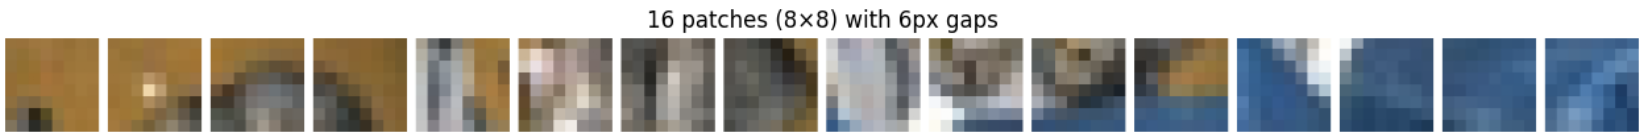

# Chapter4 Embedding

前準備は以上です。</br>
テキストのときと同様に、この分割した画像をベクトル空間に落とし込みましょう。</br>
🔘 **Options**: 以下の選択肢から選びましょう。いらないものが含まれているかもしれません。

`torch.randn` `cat` `x.size()` `nn.Module`  `PatchEmbeddings(config)` `0` `1`  

In [143]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)    
        self.cls_token = nn.Parameter(torch.randn(1, 1, 
                                      config.hidden_size))  
        num_patches = (config.image_size // config.patch_size) ** 2
        self.position_embeddings = \
        nn.Parameter(torch.randn(1,num_patches+1,config.hidden_size))  
    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        return x  

先程まで見ていた画像に組み込みます。

In [144]:
embed=Embeddings(config)

img1 = img1.unsqueeze(0) #バッチ次元を追加

out=embed(img1)

print_formatted_tensor(out)

Tensor Size: [1, 17, 48]
tensor([
         [
           [ -4.23,  -3.57,   0.86,   0.73,   0.18,  -0.57,  -1.12,  -1.20,  -0.22,   1.26,  -0.39,  -3.06,  -1.59,   0.07,   1.06,  -0.30,   3.11,  -0.54,  -1.78,   1.82,  -0.72,  -0.96,  -0.65,   0.03,  -0.12,  -0.56,   0.46,   1.84,  -1.03,  -1.99,  -1.64,   0.16,  -0.17,  -4.49,   1.01,   1.16,   0.39,  -0.15,  -1.88,   0.47,  -0.77,  -0.43,   1.36,  -1.56,  -0.88,   2.04,  -1.38,  -0.93],
           [  0.25,   1.54,   0.08,   0.02,  -0.14,  -1.41,   0.47,  -0.43,  -0.57,   1.70,   1.73,  -0.84,   0.27,  -0.97,   0.06,   0.08,  -0.50,  -0.57,   0.22,   1.11,  -1.01,   0.99,   0.70,  -0.00,   0.28,  -0.24,  -0.06,  -1.46,   0.58,  -0.05,  -0.59,   0.48,  -0.62,   0.76,   0.61,   0.67,  -0.93,  -0.14,   0.10,   0.28,  -1.07,   0.03,  -0.52,  -0.81,   0.81,  -0.70,   0.55,   1.02],
           [ -1.37,   0.35,  -1.04,   0.75,  -1.24,  -0.33,  -3.04,   0.06,   1.37,   2.25,  -1.54,  -1.78,   0.19,   0.17,   0.82,   0.79,  -2.54,   0.31,  -0.8

**`Check Point`**  <label><input type="checkbox">  以下のようなテンソルを取得できた 
</label>

# Chpater 5 Encoder
この章では、画像をベクトルに埋め込み、multi-head attentionと全結合層によって画像を高次元に飛ばします。

## self-attention

こちらはnanoGPTと同じです。前回までの復習となるので穴埋め問題だけにしますね。

In [145]:
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)   
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(\
                self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs) 

In [146]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = \
        self.hidden_size // self.num_attention_heads
        self.all_head_size = \
        self.num_attention_heads * self.attention_head_size
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size)
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size,\
                                           self.hidden_size) 
    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output,
                                      _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, 
                           attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)   

また以下のようなMLPブロックを用意しておきます。</br>
目的はAttentionの出力結果を高次元に飛ばすことです。

In [152]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size,
                                 config.intermediate_size)
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config.intermediate_size,
                                 config.hidden_size)
    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x 

このMLPブロックを用いながら、先程のmulti-head attentionを用いて、画像変換用のブロックを完成させます。

In [148]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config.hidden_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config.hidden_size)
    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
        self.attention(self.layernorm_1(x),
                       output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output  
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

この処理を以下のエンコーダブロックにまとめます。

In [149]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config.num_hidden_layers):
            block = Block(config)
            self.blocks.append(block)
    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, 
               output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

ここまでにやったこと

* 画像をパッチに分ける (PatchEmbeddings)</br>
32×32 の画像を 4×4 ピクセルのブロックに切って 64個のトークンに変換。

* 位置情報を与える (Embeddings)</br>
[CLS] トークンを先頭に追加して 65トークンにし、学習可能な位置埋め込みを加算。

* 自己注意とMLPを重ねる (Block / Encoder)</br>
Self-Attention と MLP を組み合わせたブロックを 4層積み上げて、系列全体を変換。

これでViTの大枠は完成しています。

最後にこれを「クラス分類器」とするべく、最後の操作を行います。


# Chapter 6 分類器の作成

今までのパーツ全体をクラス化し、１つのモデルにラップします。</br>
その際に、クラス分類器ですので、10クラスのどれに該当するかという情報を出力させます。



In [150]:
class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.hidden_size = config.hidden_size
        self.num_classes = config.num_classes
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size,
                                    self.num_classes)
        self.apply(self._init_weights)
    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(\
          embedding_output,output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.position_embeddings.dtype)
            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.cls_token.dtype)

これでモデルが完成しました！最後にトレーニングに入りましょう！

In [153]:

model = ViTForClassfication(config).to(device)

optimizerも用意します。</br>
optimizerとはロス関数の値を小さくするために行われるパラメータ更新の手法です。

In [154]:
from torch import nn, optim

optimizer = optim.AdamW(model.parameters(), 
                lr=0.01, weight_decay=1e-2)

In [156]:
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [157]:
class EarlyStop:
    def __init__(self, patience=3):    
        self.patience = patience
        self.steps = 0
        self.min_loss = float('inf')
    def stop(self, loss):    
        if loss < self.min_loss:    
            self.min_loss = loss
            self.steps = 0
            to_save = True
        elif loss >= self.min_loss:
            self.steps += 1
            to_save = False
        if self.steps >= self.patience:    
            to_stop = True
        else:
            to_stop = False
        return to_save, to_stop

stopper=EarlyStop()

In [158]:
def train_batch(batch):
    batch = [t.to(device) for t in batch]
    images, labels = batch
    with torch.amp.autocast(device):
        loss = loss_fn(model(images)[0], labels)
    optimizer.zero_grad() 
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()        
    return loss.item()*len(images)/len(trainloader.dataset)

In [160]:
from tqdm import tqdm
import os
os.makedirs("files", exist_ok=True)
for i in range(1):
    print(f'Epoch {i+1}')
    model.train()
    trainL, testL = 0, 0
    for batch in tqdm(trainloader):
        loss=train_batch(batch)      
        trainL+=loss
    model.eval()
    with torch.no_grad():
        for batch in testloader:
            batch = [t.to(device) for t in batch]
            images, labels = batch
            logits, _ = model(images)
            loss = loss_fn(logits, labels)
            testL+=loss.item()*len(images)/len(testloader.dataset)
    print(f'Train and test losses: {trainL:.4f}, {testL:.4f}')
    to_save, to_stop = stopper.stop(testL)
    if to_save==True:    
        torch.save(model.state_dict(),"files/ViT.pth")
    if to_stop==True:    
        break

Epoch 1


100%|██████████| 1563/1563 [03:20<00:00,  7.78it/s]


Train and test losses: 1.8109, 1.6760


# Chapter 7 分類
これで晴れて学習が完了したことになります。</br>
それではこのモデルを使って分類ができるか試してみます。

In [161]:
import math
import torch.nn.functional as F  

model.load_state_dict(torch.load('files/ViT.pth'))    
model.eval()
with torch.no_grad():
    batch=next(iter(testloader))    
    batch = [t.to(device) for t in batch]
    images, labels = batch
    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)    

print(predictions)
print([names[i] for i in predictions.tolist()])

tensor([1, 1, 8, 0, 4, 4, 1, 4, 6, 8, 8, 1, 1, 1, 9, 2, 7, 9, 9, 6, 7, 0, 0, 1,
        7, 7, 7, 6, 1, 6, 4, 7])
['car', 'car', 'ship', 'plane', 'deer', 'deer', 'car', 'deer', 'frog', 'ship', 'ship', 'car', 'car', 'car', 'truck', 'bird', 'horse', 'truck', 'truck', 'frog', 'horse', 'plane', 'plane', 'car', 'horse', 'horse', 'horse', 'frog', 'car', 'frog', 'deer', 'horse']


In [162]:
for attn in attention_maps:
    print(attn.shape)
block0_image0_head0=attention_maps[0][0,0,:,:]
print(block0_image0_head0.shape)
probs_sum=torch.sum(block0_image0_head0,dim=1)
print(probs_sum)  

torch.Size([32, 4, 17, 17])
torch.Size([32, 4, 17, 17])
torch.Size([32, 4, 17, 17])
torch.Size([32, 4, 17, 17])
torch.Size([17, 17])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


attention map shape: torch.Size([32, 16, 17, 17])
attention map shape: torch.Size([32, 16, 16])
attention map shape: torch.Size([32, 16])
attention map shape: torch.Size([32, 4, 4])
attention map shape: torch.Size([32, 32, 32])


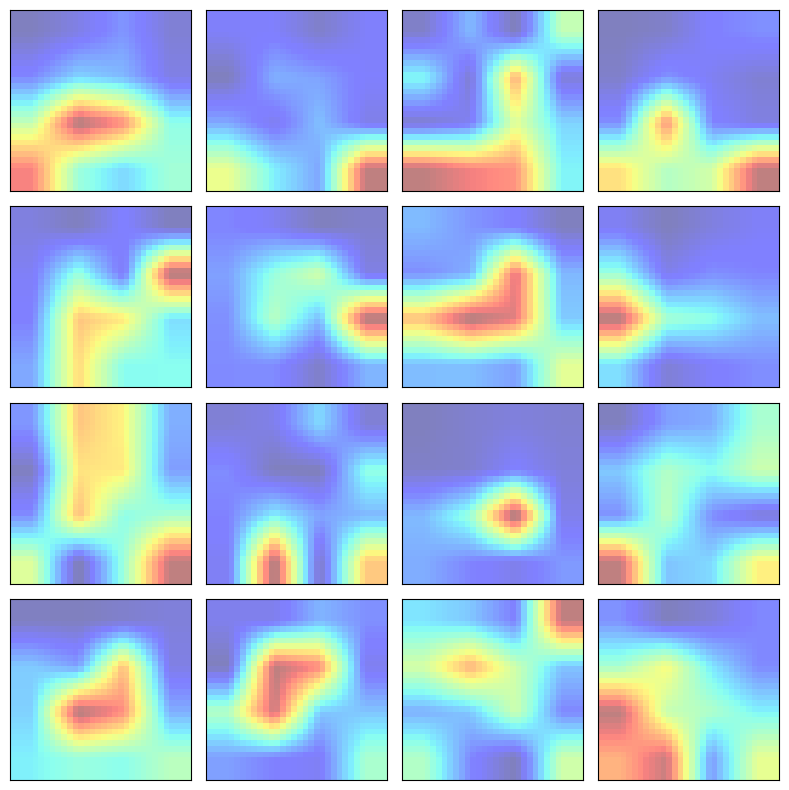

In [163]:
with torch.no_grad():
    attention_maps = torch.cat(attention_maps, dim=1)
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps[:, :, 0, 1:]
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.mean(dim=1)
    print(f"attention map shape: {attention_maps.shape}")
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32),
                       mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)    #D
    print(f"attention map shape: {attention_maps.shape}")

fig = plt.figure(figsize=(8, 8),dpi=100)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(attention_maps[i].cpu(), alpha=0.5, cmap='jet')
plt.tight_layout()
plt.show() 

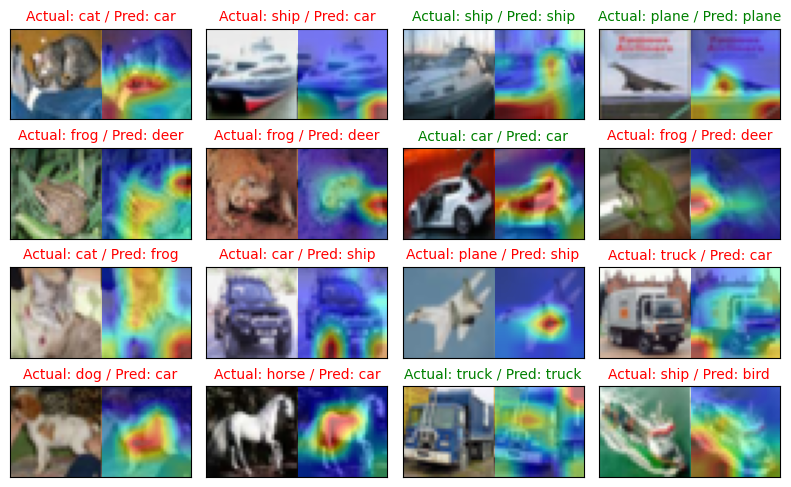

In [164]:
fig = plt.figure(figsize=(8, 5),dpi=100)
mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))],
                      axis=1)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    img = np.concatenate((images[i].cpu(), images[i].cpu()),
                         axis=-1)
    ax.imshow(img.transpose(1,2,0)/2+0.5)
    extended_attention_map = np.concatenate((np.zeros((32, 32)), 
                                     attention_maps[i].cpu()),
                                            axis=1)
    extended_attention_map = np.ma.masked_where(mask==1,
                                    extended_attention_map)
    ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
    gt = names[labels[i]]
    pred = names[predictions[i]]    
    ax.set_title(f"Actual: {gt} / Pred: {pred}", 
                 color=("green" if gt==pred else "red"),
                fontsize=10)
plt.tight_layout()
plt.show() 

最後に、スコアが問題ないかを見てみましょう。

In [165]:
model.eval()
acc = 0
with torch.no_grad():
    for batch in testloader:
        batch = [t.to(device) for t in batch]
        images, labels = batch
        logits, _ = model(images)
        predictions = torch.argmax(logits, dim=1)
        acc += torch.sum(predictions ==\
             labels).item()/ len(testloader.dataset)
print(f'the prediction accuracy is {acc:.4f}')

the prediction accuracy is 0.3675
